In [20]:
!pip install -q keras-nlp --upgrade
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir data
! kaggle competitions download -c nlp-getting-started
! unzip nlp-getting-started.zip -d data

In [ ]:
!pip install demoji

# NLP Disaster Tweet

Import necessary libraries

In [24]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import demoji
import keras_core as keras
import keras_nlp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [25]:
import warnings
warnings.filterwarnings('ignore')

Load Datasets

In [26]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [27]:
X = df_train[["id", "keyword", "location", "text"]] # Features
y = df_train[["id","target"]] #Labels


## EDA


In [28]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [30]:
df_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000



## Data Cleaning


- Remove Url
- Handle Tags
- Handle emoji's
- Remove HTML Tags
- Remove stopwords
- Removing Useless Characters and Punctuation


## Remove Url


In [31]:
def url_removal(string):
    return re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', string)

pattern = r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*'
example = X[X['text'].str.contains(pattern, regex=True, na=False)]
print(example.iloc[0]['text'])

X['text'] = X['text'].apply(url_removal)

example_id = example.iloc[0]['id']
required_text = X[X['id'] == example_id]['text'].values[0]
print(required_text)
print('\n')


del example, example_id, required_text, pattern

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
@bbcmtd Wholesale Markets ablaze 





## Handle Tags


In [32]:
def Handle_Tags(string):
    pattern = re.compile(r'[@|#][^\s]+')
    matches = pattern.findall(string)
    tags = [match[1:] for match in matches]
    # Removing tags from main string
    string = re.sub(pattern, '', string)
    # More weightage to tag by adding them 3 times
    return string + ' ' + ' '.join(tags) + ' '+ ' '.join(tags) + ' ' + ' '.join(tags)

pattern = r'[@|#][^\s]+'
example = X[X['text'].str.contains(pattern, regex=True, na=False)]
print(example.iloc[0]['text'])

X['text'] = X['text'].apply(Handle_Tags)
example_id = example.iloc[0]['id']
required_text = X[X['id'] == example_id]['text'].values[0]
print(required_text)
print('\n')


del example, example_id, required_text, pattern

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Our Deeds are the Reason of this  May ALLAH Forgive us all earthquake earthquake earthquake





## Handle emoji's


In [33]:
demoji.download_codes()

def Handle_emoji(string):
    return demoji.replace_with_desc(string)

ind = None
for index, row in X.iterrows():
    emojis = demoji.findall(row['text'])
    if emojis:
        ind = row['id']
        print(f" {row['text']}")
        break

X['text'] = X['text'].apply(Handle_emoji)
required_text = X[X['id'] == ind]['text'].values[0]
print (required_text)
print('\n')

del emojis, ind, required_text, row, index

 How Missing JetÛªs Debris Could Have Floated to RÌ©union - The New York Times    
How Missing JetÛªs Debris Could Have Floated to RÌ:copyright:union - The New York Times    




## Remove HTML Tags


In [34]:
def Remove_html(string):
    return re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', str(string))

pattern = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
example = X[X['text'].str.contains(pattern, regex=True, na=False)]
print(example.iloc[0]['text'])

X['text'] = X['text'].apply(Remove_html)
example_id = example.iloc[0]['id']
required_text = X[X['id'] == example_id]['text'].values[0]
print(required_text)
print('\n')


del example, example_id, required_text, pattern

Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013     
Rene Ablaze  Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013     





## Remove Stopwords and Stemming




In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
stemmer = SnowballStemmer('english')
stopword = set(stopwords.words('english'))

def Remove_StopAndStem(string):
    string_list = string.split()
    return ' '.join([stemmer.stem(i) for i in string_list if i not in stopword])

print( X.iloc[14]['text'])

X['text'] = X['text'].apply(Remove_StopAndStem)
print( X.iloc[14]['text'])
print('\n')

Damage to school bus on 80 in multi car crash   BREAKING BREAKING BREAKING
damag school bus 80 multi car crash break break break





## Removing Useless Characters and Punctuation

In [37]:
def Remove_UC(string):
   thestring = re.sub(r'[^a-zA-Z\s]','', string)
   return re.sub(' +', ' ', thestring)

pattern = r'[^a-zA-Z\s]'
example = X[X['text'].str.contains(pattern, regex=True, na=False)]
print(example.iloc[0]['text'])

X['text'] = X['text'].apply(Remove_UC)
example_id = example.iloc[0]['id']
required_text = X[X['id'] == example_id]['text'].values[0]
print(required_text)
print('\n')


del example, example_id, required_text, pattern

forest fire near la rong sask. canada
forest fire near la rong sask canada




# NLP Model


In [38]:
processed = pd.merge(X, y, on = 'id')
X = processed[["keyword", "location", "text"]]
y = processed[['target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data", len(y_train))
print("Validating Data", len(y_val))

Training Data 6090
Validating Data 1523


In [41]:
BATCH_SIZE = 32
EPOCHS = 3


preset= "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=2)

classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.AdamW(1e-5),
    metrics= ["accuracy"]
)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_2 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone_2 (DistilBertBackbone)   │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_2 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = classifier.fit(x=X_train['text'],
                         y=y_train['target'],
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val['text'], y_val['target'])
                        )

Epoch 1/3
191/191 [==============================] - 137s 573ms/step - loss: 0.5365 - accuracy: 0.7396 - val_loss: 0.4489 - val_accuracy: 0.8083
Epoch 2/3
191/191 [==============================] - 153s 800ms/step - loss: 0.4256 - accuracy: 0.8154 - val_loss: 0.4304 - val_accuracy: 0.8221
Epoch 3/3
191/191 [==============================] - 107s 563ms/step - loss: 0.3649 - accuracy: 0.8502 - val_loss: 0.4296 - val_accuracy: 0.8240


Previous versions of the model had more epochs but were overfitting
>accuracy: 0.9417 - loss: 0.1577 - val_accuracy: 0.7695 - val_loss: 0.7409

Model Accuracy

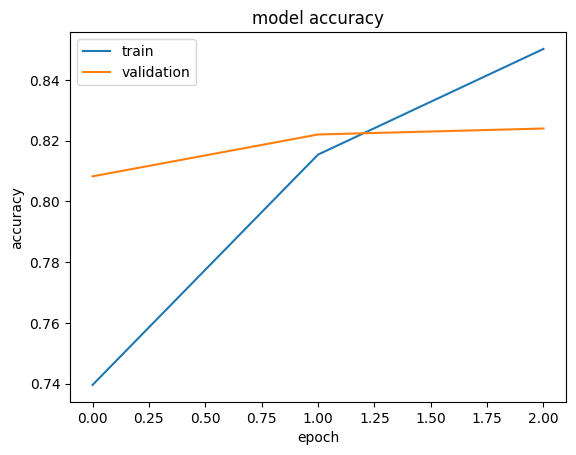

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Model Loss

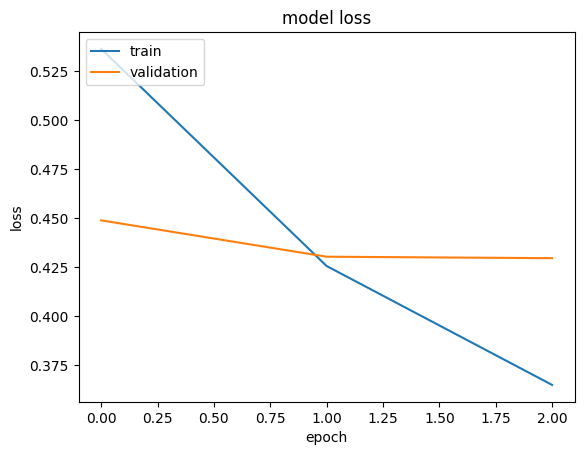

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Kaggle submission

In [ ]:
#sample_submission = pd.read_csv(r"C:\Users\dadac\OneDrive - SUPSI\04_DeepLearning\Week 4\Project\nlp-getting-started\sample_submission.csv")
#sample_submission.head()

#prediction = classifier.predict(df_test['text'])
#prediction = np.argmax(prediction, axis = 1)
#dat = pd.DataFrame({'id': df_test['id'], 'target': prediction})

#dat.to_csv("submission.csv", index=False)